In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.io import wavfile
from IPython.display import Audio
import import_ipynb
import Helpers

figsize=(10,5)

importing Jupyter notebook from Helpers.ipynb


# Data generation

To start, let's generate input output data

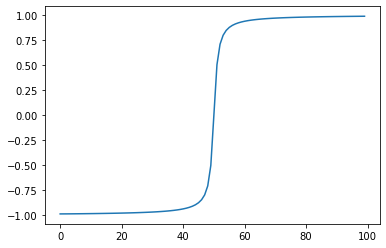

In [2]:
def linearOperator(x):
    # y[n] = x[n] - 0.5 x[n-1] + 0.5 x[n-2]
     return  x \
            - 0.5 * np.concatenate((np.full(1, x[0]),x))[:x.size] \
            + 0.5 * np.concatenate((np.full(2, x[0]),x))[:x.size]
    # return x

def nonLinearFunction(x):
    # return 3*x/2 * (1- x**2 /3) # Distorsion proposed by Araya(1996)
    # return (np.abs(2*x) - x**2 )*np.sign(x) # Distorsion proposed by Diodic(1998)
     return 2/np.pi * np.arctan(50*x) # Hard clipping distortion

plt.plot(nonLinearFunction(linearOperator(np.linspace(-1,1,100))))

In [3]:
# Constants

p=15 # Maximum degree of the Volterra series
N=200 # test size

In [4]:
# Generate training data
x_train = np.random.rand(N) *2 -1 # Random input values in [-1,1]
x_oversampled = signal.resample(x_train, x_train.size * 8) # Oversampling to avoid harmonic generation
y_oversampled = nonLinearFunction(linearOperator(x_oversampled)) # Corresponding nonlinear output values
y_train = signal.resample(y_oversampled, int(y_oversampled.size/8) ) # Downsampling

# Training the Volterra kernels

In [5]:
def a(n):
    return np.sqrt(1/math.factorial(n))

def kp(x1, x2):
    return np.sum( np.fromiter( (a(n)**2 * (x1*x2)**n for n in range(0,p) ), float) )

kp_vec = np.vectorize(kp, excluded=["x1"])

def kpVec(xnew, x):
    return (kp_vec(xnew, x)).T

In [6]:
# Global computation of the Gram Matrix K
Kp = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        Kp[i,j] = kp(x_train[i], x_train[j])
        
KpInv = np.linalg.pinv(Kp)

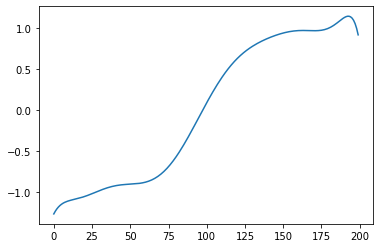

In [7]:
def volterraEstimation(newx, x, y):
    
    return y.T @ KpInv @ kpVec(newx, x)

plt.plot( [volterraEstimation(i, x_train, y_train) for i in np.arange(-1,1,0.01)])

In [8]:
def volterraFilter(x):
    y = np.zeros(x.size)
    
    for i in range(x.size):
        y[i] = volterraEstimation(x[i], x_train, y_train)
        
    return y

# Test with a half unit impulse response

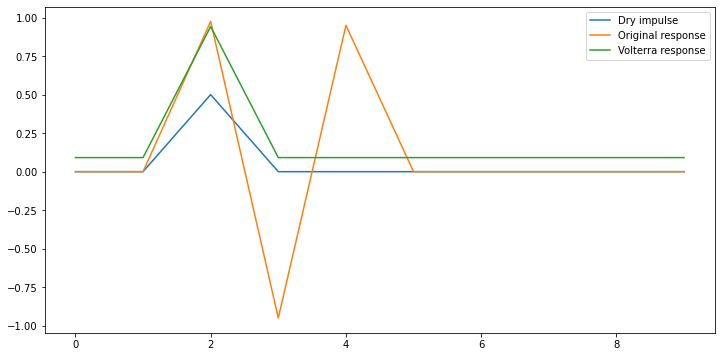

In [9]:
impulse = np.zeros(10)
impulse[2] = .5

originalImpulseResponse = nonLinearFunction(linearOperator(impulse))
volterraImpulseResponse = volterraFilter(impulse)

plt.figure(figsize=(12,6))
plt.plot(impulse, label='Dry impulse')
plt.plot(originalImpulseResponse, label='Original response')
plt.plot(volterraImpulseResponse, label='Volterra response')
plt.legend()
plt.show()

# Test with actual guitar

In [10]:
fs, guitar_clean = wavfile.read('samples/guitar.wav')
guitar_clean = np.array(guitar_clean, dtype=np.float32)
guitar_clean /= np.max(np.abs(guitar_clean) )
fs, guitar_disto = wavfile.read('samples/guitar_disto_original.wav')
guitar_disto = np.array(guitar_disto, dtype=np.float32)
guitar_disto /= np.max(np.abs(guitar_disto) )

In [11]:
Audio("samples/guitar.wav", autoplay=False)

In [12]:
Audio("samples/guitar_disto_original.wav", autoplay=False)

In [13]:
# Train the model with the guitar
x_train = guitar_clean[50000: 50000+N]
y_train = guitar_disto[50000: 50000+N]

In [14]:
# Global computation of the Gram Matrix K
Kp = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        Kp[i,j] = kp(x_train[i], x_train[j])
        
KpInv = np.linalg.pinv(Kp)

In [ ]:
guitar_disto_volterra = volterraFilter(guitar_clean)

In [ ]:
wavfile.write('samples/guitar_disto_volterra.wav', fs, (0x7FFF * guitar_disto_volterra).astype(np.int16))
Audio("samples/guitar_disto_volterra.wav", autoplay=False)